<a href="https://colab.research.google.com/github/Abbessi-zouhour/drug_interaction/blob/master/FinalVersionExcipientInteraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [3]:
# ------------------ Imports ------------------
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import keras_tuner as kt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)


# ------------------ Load Dataset ------------------
df = pd.read_csv("/content/drive/MyDrive/Drug-Excipient-Interaction-Prediction-main/DEL.csv")

# Prepare features and labels
# Select columns starting with 'PubchemFP' for features
X = df.filter(like='PubchemFP').values
# Use 'Output Value' column for labels
Y = df['Output Value'].values
le = LabelEncoder()
Y = le.fit_transform(Y)

# Train/val/test split
train, test = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

# ------------------ Early Stopping ------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ------------------ Build Model Function ------------------
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(X.shape[1],)))

    # Tune number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=256, max_value=1024, step=128),
            activation='relu'))
        model.add(tf.keras.layers.Dropout(
            hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# ------------------ Hyperparameter Search ------------------
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='excipient_interaction_tuning'
)

# Run the tuner
tuner.search(X[train], Y[train],
             epochs=50,
             validation_data=(X[val], Y[val]),
             callbacks=[early_stop],
             verbose=1)

Trial 10 Complete [00h 00m 45s]
val_accuracy: 0.979411780834198

Best val_accuracy So Far: 0.9911764860153198
Total elapsed time: 00h 14m 21s


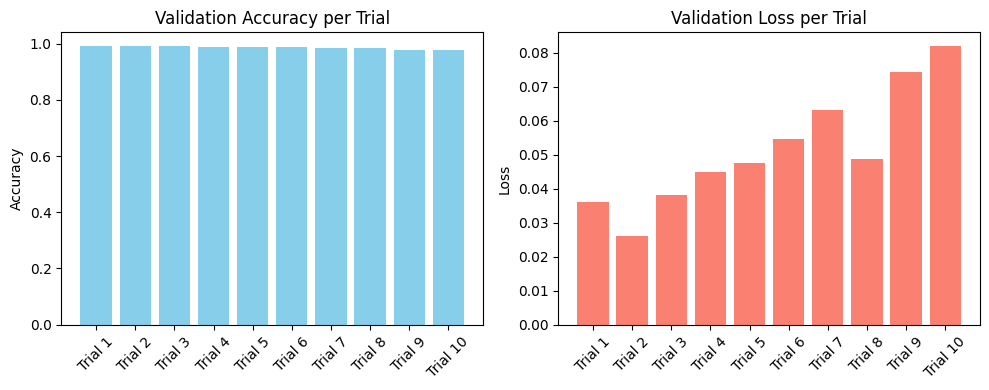


🔧 Top Hyperparameter Configurations:

Trial 1:
  num_layers: 2
  units_0: 1024
  dropout_0: 0.0
  learning_rate: 0.0001
  units_1: 640
  dropout_1: 0.4
  units_2: 768
  dropout_2: 0.30000000000000004
  val_accuracy: 0.9912

Trial 2:
  num_layers: 3
  units_0: 768
  dropout_0: 0.0
  learning_rate: 0.0001
  units_1: 768
  dropout_1: 0.1
  units_2: 768
  dropout_2: 0.2
  val_accuracy: 0.9912

Trial 3:
  num_layers: 1
  units_0: 768
  dropout_0: 0.0
  learning_rate: 0.0001
  val_accuracy: 0.9912

Trial 4:
  num_layers: 1
  units_0: 640
  dropout_0: 0.2
  learning_rate: 0.0001
  units_1: 512
  dropout_1: 0.1
  units_2: 1024
  dropout_2: 0.2
  val_accuracy: 0.9897

Trial 5:
  num_layers: 2
  units_0: 256
  dropout_0: 0.0
  learning_rate: 0.01
  units_1: 768
  dropout_1: 0.4
  units_2: 1024
  dropout_2: 0.30000000000000004
  val_accuracy: 0.9882

Trial 6:
  num_layers: 1
  units_0: 384
  dropout_0: 0.4
  learning_rate: 0.0001
  units_1: 640
  dropout_1: 0.2
  units_2: 640
  dropout_2: 0.4
  

In [5]:


# ------------------ Visualize Tuning Results ------------------

# Get all trials
results = tuner.oracle.get_best_trials(num_trials=10)

# Extract accuracy and loss per trial
val_accuracies = [trial.metrics.get_last_value('val_accuracy') for trial in results]
val_losses = [trial.metrics.get_last_value('val_loss') for trial in results]
trial_ids = [f'Trial {i+1}' for i in range(len(results))]

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(trial_ids, val_accuracies, color='skyblue')
plt.title('Validation Accuracy per Trial')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Plot loss
plt.subplot(1, 2, 2)
plt.bar(trial_ids, val_losses, color='salmon')
plt.title('Validation Loss per Trial')
plt.ylabel('Loss')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ------------------ Print Top Hyperparameter Configurations ------------------
print("\n🔧 Top Hyperparameter Configurations:")
for i, trial in enumerate(results):
    print(f"\nTrial {i+1}:")
    for key, value in trial.hyperparameters.values.items():
        print(f"  {key}: {value}")
    print(f"  val_accuracy: {trial.metrics.get_last_value('val_accuracy'):.4f}")


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8335 - loss: 0.3997 - val_accuracy: 0.8882 - val_loss: 0.2461
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9096 - loss: 0.2275 - val_accuracy: 0.9382 - val_loss: 0.1723
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9363 - loss: 0.1593 - val_accuracy: 0.9706 - val_loss: 0.1211
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9593 - loss: 0.1137 - val_accuracy: 0.9706 - val_loss: 0.0901
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9728 - loss: 0.0839 - val_accuracy: 0.9794 - val_loss: 0.0686
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9774 - loss: 0.0707 - val_accuracy: 0.9853 - val_loss: 0.0558
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9783 - loss: 0.0579 - val_accuracy: 0.9824 - val_loss: 0.0527
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9832 - loss: 0.0544 - val_accuracy: 0.9941 - v

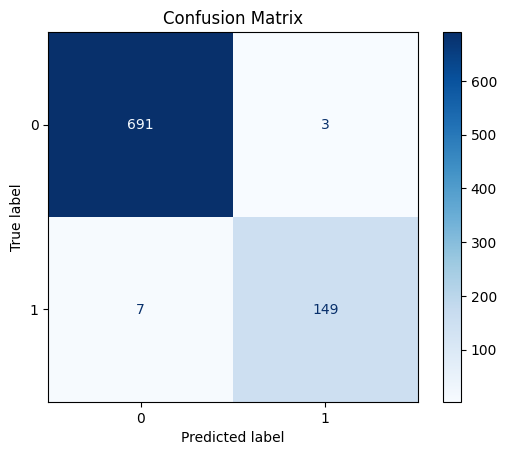

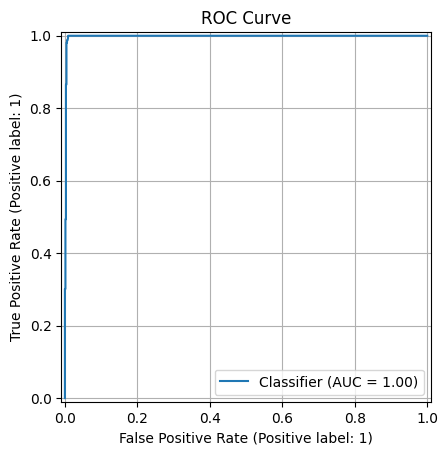


✅ Best hyperparameters found:
{'num_layers': 2, 'units_0': 1024, 'dropout_0': 0.0, 'learning_rate': 0.0001, 'units_1': 640, 'dropout_1': 0.4, 'units_2': 768, 'dropout_2': 0.30000000000000004}

📊 Final test accuracy: 0.9882


In [8]:
# ------------------ Train the Best Model ------------------
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

# Retrain on train + val
X_combined = np.concatenate([X[train], X[val]])
Y_combined = np.concatenate([Y[train], Y[val]])

history = best_model.fit(
    X_combined, Y_combined,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# ------------------ Evaluate on Test Set ------------------
X_test = X[test]
Y_test = Y[test]

# Predict probabilities and binary outputs
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Flatten for sklearn metrics
y_true = Y_test.flatten()
y_pred_flat = y_pred.flatten()

# Metrics
accuracy = accuracy_score(y_true, y_pred_flat)
precision = precision_score(y_true, y_pred_flat)
recall = recall_score(y_true, y_pred_flat)
f1 = f1_score(y_true, y_pred_flat)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_flat)

# Print all scores
print(f"Test Accuracy:  {accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"ROC AUC Score:  {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(cm)
# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Plot ROC Curve
RocCurveDisplay.from_predictions(y_true, y_pred_prob)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

test_loss, test_acc = best_model.evaluate(X[test], Y[test], verbose=0)
print("\n✅ Best hyperparameters found:")
print(best_hp.values)

print(f"\n📊 Final test accuracy: {test_acc:.4f}")

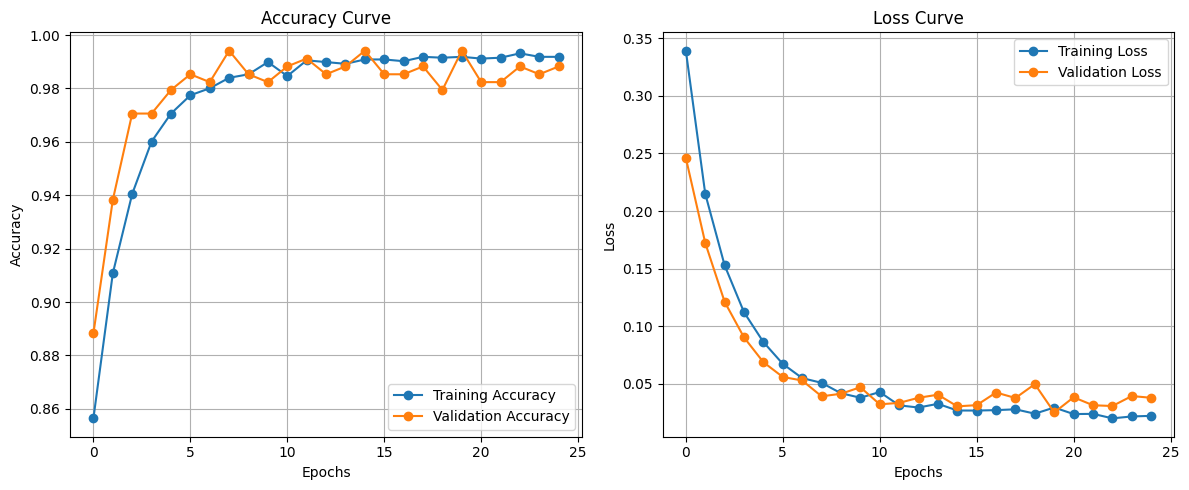

In [9]:
# ------------------ Plot Training History ------------------
plt.figure(figsize=(12, 5))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
